# Capstone Project - An analysis of my local house market

### An introduction

This project aims at analysing the house prices in my local town **Hitchin, England**. This research would hopefully provides useful infomation for protential home buyers. I will look at:
- What are the most frequent listing type? (Flat, Terrace, Semi-detached or detached)
- What are the most frequent listing property size? (1,2,3,4+ bedrooms)
- What areas are there in Hitch?
- What venues are available in each area?

A case study will be used as an example, this involoves an imaginate A who wants to purchase a 3 bedrooms property in Hitch. We will look at different options of listings on rightmove.com and analyse the different regions in Hitchin.

Different form of data will be gathered from multiple sources using inculding the **Foursquare API** and some self-developed scrips. I will aim at collecting housing information from the **rightmove.com** which is a popular house search website in the United Kingdom. During the research, I found that there are libraries written by other developers (credit to toby-p) available in Github to scrape the rightmove.com, I will try to use them for convenience. 

#### Below is a picture of my local town center!

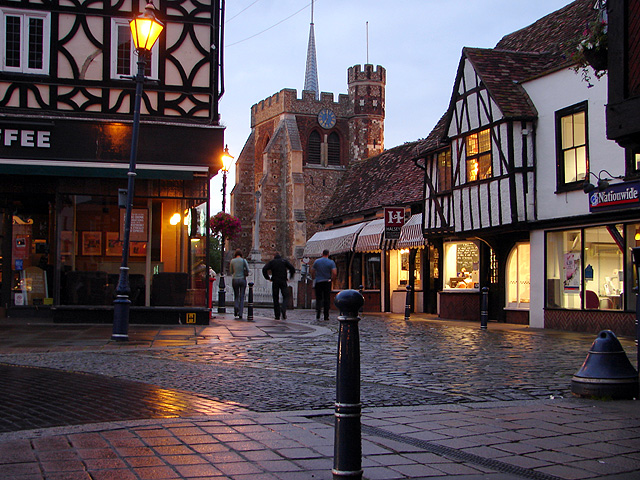

In [48]:
import requests
import IPython.display as Disp
url_pic = 'https://upload.wikimedia.org/wikipedia/commons/c/cc/St_Mary%27s_Church%2C_Hitchin_-_geograph.org.uk_-_989830.jpg'
Disp.Image(requests.get(url_pic).content)

### Data collection 
**Now we will load the scrape rightmove.com function for future use. The search will gather below information:**
- price
- Type
- Address
- URL 
- agent_url
- postcode
- number_bedrooms
- search_date
 

In [2]:
import datetime as dt
from lxml import html
import numpy as np
import pandas as pd
import requests


class RightmoveData:
    """The `RightmoveData` webscraper collects structured data on properties
    returned by a search performed on www.rightmove.co.uk
    An instance of the class provides attributes to access data from the search
    results, the most useful being `get_results`, which returns all results as a
    Pandas DataFrame object.
    The query to rightmove can be renewed by calling the `refresh_data` method.
    """
    def __init__(self, url: str, get_floorplans: bool = False):
        """Initialize the scraper with a URL from the results of a property
        search performed on www.rightmove.co.uk.
        Args:
            url (str): full HTML link to a page of rightmove search results.
            get_floorplans (bool): optionally scrape links to the individual
                floor plan images for each listing (be warned this drastically
                increases runtime so is False by default).
        """
        self._status_code, self._first_page = self._request(url)
        self._url = url
        self._validate_url()
        self._results = self._get_results(get_floorplans=get_floorplans)

    @staticmethod
    def _request(url: str):
        r = requests.get(url)
        return r.status_code, r.content

    def refresh_data(self, url: str = None, get_floorplans: bool = False):
        """Make a fresh GET request for the rightmove data.
        Args:
            url (str): optionally pass a new HTML link to a page of rightmove
                search results (else defaults to the current `url` attribute).
            get_floorplans (bool): optionally scrape links to the individual
                flooplan images for each listing (this drastically increases
                runtime so is False by default).
        """
        url = self.url if not url else url
        self._status_code, self._first_page = self._request(url)
        self._url = url
        self._validate_url()
        self._results = self._get_results(get_floorplans=get_floorplans)

    def _validate_url(self):
        """Basic validation that the URL at least starts in the right format and
        returns status code 200."""
        real_url = "{}://www.rightmove.co.uk/{}/find.html?"
        protocols = ["http", "https"]
        types = ["property-to-rent", "property-for-sale", "new-homes-for-sale"]
        urls = [real_url.format(p, t) for p in protocols for t in types]
        conditions = [self.url.startswith(u) for u in urls]
        conditions.append(self._status_code == 200)
        if not any(conditions):
            raise ValueError(f"Invalid rightmove search URL:\n\n\t{self.url}")

    @property
    def url(self):
        return self._url

    @property
    def get_results(self):
        """Pandas DataFrame of all results returned by the search."""
        return self._results

    @property
    def results_count(self):
        """Total number of results returned by `get_results`. Note that the
        rightmove website may state a much higher number of results; this is
        because they artificially restrict the number of results pages that can
        be accessed to 42."""
        return len(self.get_results)

    @property
    def average_price(self):
        """Average price of all results returned by `get_results` (ignoring
        results which don't list a price)."""
        total = self.get_results["price"].dropna().sum()
        return total / self.results_count

    def summary(self, by: str = None):
        """DataFrame summarising results by mean price and count. Defaults to
        grouping by `number_bedrooms` (residential) or `type` (commercial), but
        accepts any column name from `get_results` as a grouper.
        Args:
            by (str): valid column name from `get_results` DataFrame attribute.
        """
        if not by:
            by = "type" if "commercial" in self.rent_or_sale else "number_bedrooms"
        assert by in self.get_results.columns, f"Column not found in `get_results`: {by}"
        df = self.get_results.dropna(axis=0, subset=["price"])
        groupers = {"price": ["count", "mean"]}
        df = df.groupby(df[by]).agg(groupers)
        df.columns = df.columns.get_level_values(1)
        df.reset_index(inplace=True)
        if "number_bedrooms" in df.columns:
            df["number_bedrooms"] = df["number_bedrooms"].astype(int)
            df.sort_values(by=["number_bedrooms"], inplace=True)
        else:
            df.sort_values(by=["count"], inplace=True, ascending=False)
        return df.reset_index(drop=True)

    @property
    def rent_or_sale(self):
        """String specifying if the search is for properties for rent or sale.
        Required because Xpaths are different for the target elements."""
        if "/property-for-sale/" in self.url or "/new-homes-for-sale/" in self.url:
            return "sale"
        elif "/property-to-rent/" in self.url:
            return "rent"
        elif "/commercial-property-for-sale/" in self.url:
            return "sale-commercial"
        elif "/commercial-property-to-let/" in self.url:
            return "rent-commercial"
        else:
            raise ValueError(f"Invalid rightmove URL:\n\n\t{self.url}")

    @property
    def results_count_display(self):
        """Returns an integer of the total number of listings as displayed on
        the first page of results. Note that not all listings are available to
        scrape because rightmove limits the number of accessible pages."""
        tree = html.fromstring(self._first_page)
        xpath = """//span[@class="searchHeader-resultCount"]/text()"""
        return int(tree.xpath(xpath)[0].replace(",", ""))

    @property
    def page_count(self):
        """Returns the number of result pages returned by the search URL. There
        are 24 results per page. Note that the website limits results to a
        maximum of 42 accessible pages."""
        page_count = self.results_count_display // 24
        if self.results_count_display % 24 > 0:
            page_count += 1
        # Rightmove will return a maximum of 42 results pages, hence:
        if page_count > 42:
            page_count = 42
        return page_count

    def _get_page(self, request_content: str, get_floorplans: bool = False):
        """Method to scrape data from a single page of search results. Used
        iteratively by the `get_results` method to scrape data from every page
        returned by the search."""
        # Process the html:
        tree = html.fromstring(request_content)

        # Set xpath for price:
        if "rent" in self.rent_or_sale:
            xp_prices = """//span[@class="propertyCard-priceValue"]/text()"""
        elif "sale" in self.rent_or_sale:
            xp_prices = """//div[@class="propertyCard-priceValue"]/text()"""
        else:
            raise ValueError("Invalid URL format.")

        # Set xpaths for listing title, property address, URL, and agent URL:
        xp_titles = """//div[@class="propertyCard-details"]\
        //a[@class="propertyCard-link"]\
        //h2[@class="propertyCard-title"]/text()"""
        xp_addresses = """//address[@class="propertyCard-address"]//span/text()"""
        xp_weblinks = """//div[@class="propertyCard-details"]//a[@class="propertyCard-link"]/@href"""
        xp_agent_urls = """//div[@class="propertyCard-contactsItem"]\
        //div[@class="propertyCard-branchLogo"]\
        //a[@class="propertyCard-branchLogo-link"]/@href"""

        # Create data lists from xpaths:
        price_pcm = tree.xpath(xp_prices)
        titles = tree.xpath(xp_titles)
        addresses = tree.xpath(xp_addresses)
        base = "http://www.rightmove.co.uk"
        weblinks = [f"{base}{tree.xpath(xp_weblinks)[w]}" for w in range(len(tree.xpath(xp_weblinks)))]
        agent_urls = [f"{base}{tree.xpath(xp_agent_urls)[a]}" for a in range(len(tree.xpath(xp_agent_urls)))]

        # Optionally get floorplan links from property urls (longer runtime):
        floorplan_urls = list() if get_floorplans else np.nan
        if get_floorplans:
            for weblink in weblinks:
                status_code, content = self._request(weblink)
                if status_code != 200:
                    continue
                tree = html.fromstring(content)
                xp_floorplan_url = """//*[@id="floorplanTabs"]/div[2]/div[2]/img/@src"""
                floorplan_url = tree.xpath(xp_floorplan_url)
                if floorplan_url:
                    floorplan_urls.append(floorplan_url[0])
                else:
                    floorplan_urls.append(np.nan)

        # Store the data in a Pandas DataFrame:
        data = [price_pcm, titles, addresses, weblinks, agent_urls]
        data = data + [floorplan_urls] if get_floorplans else data
        temp_df = pd.DataFrame(data)
        temp_df = temp_df.transpose()
        columns = ["price", "type", "address", "url", "agent_url"]
        columns = columns + ["floorplan_url"] if get_floorplans else columns
        temp_df.columns = columns

        # Drop empty rows which come from placeholders in the html:
        temp_df = temp_df[temp_df["address"].notnull()]

        return temp_df

    def _get_results(self, get_floorplans: bool = False):
        """Build a Pandas DataFrame with all results returned by the search."""
        results = self._get_page(self._first_page, get_floorplans=get_floorplans)

        # Iterate through all pages scraping results:
        for p in range(1, self.page_count + 1, 1):

            # Create the URL of the specific results page:
            p_url = f"{str(self.url)}&index={p * 24}"

            # Make the request:
            status_code, content = self._request(p_url)

            # Requests to scrape lots of pages eventually get status 400, so:
            if status_code != 200:
                break

            # Create a temporary DataFrame of page results:
            temp_df = self._get_page(content, get_floorplans=get_floorplans)

            # Concatenate the temporary DataFrame with the full DataFrame:
            frames = [results, temp_df]
            results = pd.concat(frames)

        # Reset the index:
        results.reset_index(inplace=True, drop=True)

        # Convert price column to numeric type:
        results["price"].replace(regex=True, inplace=True, to_replace=r"\D", value=r"")
        results["price"] = pd.to_numeric(results["price"])

        # Extract postcodes to a separate column:
        pat = r"\b([A-Za-z][A-Za-z]?[0-9][0-9]?[A-Za-z]?)\b"
        results["postcode"] = results["address"].astype(str).str.extract(pat, expand=True)

        # Extract number of bedrooms from `type` to a separate column:
        pat = r"\b([\d][\d]?)\b"
        results["number_bedrooms"] = results["type"].astype(str).str.extract(pat, expand=True)
        results.loc[results["type"].str.contains("studio", case=False), "number_bedrooms"] = 0
        results["number_bedrooms"] = pd.to_numeric(results["number_bedrooms"])

        # Clean up annoying white spaces and newlines in `type` column:
        results["type"] = results["type"].str.strip("\n").str.strip()

        # Add column with datetime when the search was run (i.e. now):
        now = dt.datetime.today()
        results["search_date"] = now

        return results

Now I will inlitialise the Rightmove scrape class by entering an URL with the result of a search of property on sale in **Hitchin** on Rightmove.com.

In [3]:
# below is the url based on a search on rightmove.com for all properties in Hitchi
url = 'https://www.rightmove.co.uk/property-for-sale/find.html?searchType=SALE&locationIdentifier=REGION%5E643&insId=1&radius=0.0&minPrice=&maxPrice=&minBedrooms=&maxBedrooms=&displayPropertyType=&maxDaysSinceAdded=&_includeSSTC=on&sortByPriceDescending=&primaryDisplayPropertyType=&secondaryDisplayPropertyType=&oldDisplayPropertyType=&oldPrimaryDisplayPropertyType=&newHome=&auction=false'
# create an instance 
rm = RightmoveData(url)

We can now have all the propert listings in Hitchin available on the rightmove.com, and we will have info about their price, type, address, number of bedrooms etc. A snapshot of the dataframe is shown below: 

In [4]:
# create a dataframe to show all listings in Hitchin 
hitchin_house = rm.get_results
hitchin_house.head()

,price,type,address,url,agent_url,postcode,number_bedrooms,search_date
0,575000.0,3 bedroom end of terrace house for sale,"Store House Lane, Hitchin, Hertfordshire",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,NaN,3.0,2020-07-27 12:11:41.578682
1,2000000.0,6 bedroom house for sale,"Tilehouse Street, Hitchin, Hertfordshire, SG5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG5,6.0,2020-07-27 12:11:41.578682
2,1800000.0,5 bedroom detached house for sale,"London Road, St Ippolyts, Hitchin, SG4",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG4,5.0,2020-07-27 12:11:41.578682
3,1750000.0,6 bedroom detached house for sale,"Highbury Road, Hitchin, SG4",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG4,6.0,2020-07-27 12:11:41.578682
4,1750000.0,4 bedroom detached house for sale,"Priory Way, Hitchin, Hertfordshire, SG4",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG4,4.0,2020-07-27 12:11:41.578682


In [79]:
# how many properties are listed at the moment 
hitchin_house.shape

(253, 8)

### Data Exploration 

#### The most populars!

#### 1. Amount of bedrooms

We can see from the below dataframe that the most frequently listed porperties size is 2 bedrooms, then followed by 3 bedrooms and 1 bedroom.

In [161]:
# number of listings by bedroom amounts, need to use .reset_index() to store in pandas df
hitchin_grouped = hitchin_house.groupby('number_bedrooms')['address'].count().reset_index()

# reset column names
hitchin_grouped = hitchin_grouped.rename(columns={'number_bedrooms': 'Rooms', 'address':'Listings'})

hitchin_grouped.sort_values(by='Listings', ascending=False)

,Rooms,Listings
1,2.0,89
2,3.0,57
0,1.0,52
3,4.0,36
4,5.0,9
5,6.0,5


<Figure size 432x288 with 0 Axes>

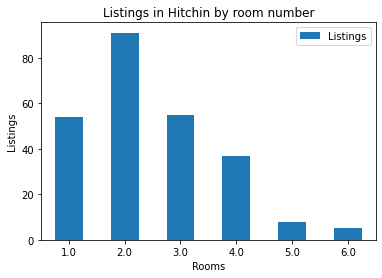

In [95]:
# visualise above
import matplotlib.pyplot as plt
fig = plt.figure()
ax = hitchin_grouped.plot.bar(x='Rooms', y='Listings', rot=0)

plt.ylabel('Listings')
plt.title('Listings in Hitchin by room number')

plt.show()

#### 2. Area by postcode

From the below dataframe, we can see that there are two postal areas in **Hitchin**, and they have very similar amount of listing availbe while SG4 has slighly more.

In [103]:
# number of listings by postcode, need to use .reset_index() to store in pandas df
hitchin_area = hitchin_house.groupby('postcode')['address'].count().reset_index()

# reset column names
hitchin_area = hitchin_area.rename(columns={'postcode': 'Postcode', 'address':'Listings'})

hitchin_area

,Postcode,Listings
0,SG4,88
1,SG5,81


#### 3. Average 3 beds in SG4

Assumeing that we have Mr.A who wants to buy a **3 bedrooms** property in **SG4 area**, we want know the below so that we can halp Mr.A to decide what budget he should have if he wants to find an apporiate property within the area:
- Average price 
- Max/Min price 


In [120]:
hitchin3beds = hitchin_house.loc[hitchin_house['number_bedrooms'] == 3]
print("The most expensive 3 beds property offed costs £", hitchin3beds['price'].max())
print("The cheapest 3 beds property offed costs £", hitchin3beds['price'].min())
print("An average 3 beds property offed costs £", hitchin3beds['price'].mean().round(2))

The most expensive 3 beds property offed costs £ 750000.0
The cheapest 3 beds property offed costs £ 249995.0
An average 3 beds property offed costs £ 478089.91


Now Mr.A can have an idea of how to set his budget for buying a 3 bedrooms property in **Hitchin**.

#### 4. Popular property type

After knowing the budget, we want to find out which property type is most frequently listed in **Hitchin** so that Mr.A can have an idea of what kind of property he will mostly likely to find in the area.

In [162]:
# how many listing of flats 
hitchin_flat = hitchin_house['type'].str.contains('flat',na=False, regex=True).value_counts()[True]
print( "Hitchin currently has",hitchin_flat,"flats on sale")

Hitchin currently has 42 flats on sale


In [163]:
# how many listing of terrace
hitchin_terrace = hitchin_house['type'].str.contains('terrace',na=False, regex=True).value_counts()[True]
print( "Hitchin currently has",hitchin_terrace,"terrace on sale")

Hitchin currently has 35 terrace on sale


In [164]:
# how many listing of detached
hitchin_detached = hitchin_house['type'].str.contains('detached',na=False, regex=True).value_counts()[True]
print( "Hitchin currently has",hitchin_detached,"detached houses on sale")

Hitchin currently has 76 detached houses on sale


In [165]:
# how many listing of semi-detached
hitchin_semi = hitchin_house['type'].str.contains('semi-detached',na=False, regex=True).value_counts()[True]
print( "Hitchin currently has",hitchin_semi,"semi-detached houses on sale")

Hitchin currently has 43 semi-detached houses on sale


Now we can see that the most frequently offerd type of property in **Hitchin** is dettached, and there are currently 78 listings.

### Methodology

#### Case Study

After considering the above infomation about the **Hitchin** housing market, Mr. A decided he wants to buy a property with at least **3 bedrooms** within his budget of **£350K**. 

We shall look at the options for him, and analyse different option's nearby venues. We can do this by using the Foursquares API to request for location data.

##### 1. Find all the listings meet A's requirements

In [156]:
# new dataframe house_A contains all listings that are <350K and has at least 3 bedrooms
house_A = hitchin_house[(hitchin_house['price'] <350000) & (hitchin_house['number_bedrooms'] >= 3) ].reset_index()
house_A = house_A.drop(['index'],axis = 1)

Unfortuntly there is no postcode information available for some of the properties found, for convient I found these 3 from google and updated the dataframe to contain price, type, address, postcode and bedrooms.

In [158]:
house_A.loc[house_A['address']== "Desborough Road, Hitchin", ['postcode']] = 'SG4'
house_A.loc[house_A['address']== "Milestone Road, Hitchin", ['postcode']] = 'SG5'
house_A.loc[house_A['address']== "Shepherds Mead, Hitchin", ['postcode']] = 'SG5'

house_ = house_A.copy()

In [159]:
# sort the df by price (assending)
house_A.sort_values(by='price', ascending=True)

,price,type,address,url,agent_url,postcode,number_bedrooms,search_date
6,249995.0,3 bedroom maisonette for sale,"Shepherds Mead, Hitchin",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG5,3.0,2020-07-27 12:11:41.578682
5,300000.0,3 bedroom house for sale,"Desborough Road, Hitchin",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG4,3.0,2020-07-27 12:11:41.578682
3,325000.0,4 bedroom semi-detached house for sale,"Milestone Road, Hitchin, SG5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG5,4.0,2020-07-27 12:11:41.578682
4,325000.0,4 bedroom house for sale,"Milestone Road, Hitchin",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG5,4.0,2020-07-27 12:11:41.578682
1,335000.0,3 bedroom terraced house for sale,"Chaucer Way, Hitchin, SG4",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG4,3.0,2020-07-27 12:11:41.578682
2,335000.0,3 bedroom semi-detached house for sale,"Walnut Way, Ickleford, Hitchin, SG5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG5,3.0,2020-07-27 12:11:41.578682
0,345000.0,3 bedroom town house for sale,"Chaucer Way, Hitchin, Herts, SG4",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SG4,3.0,2020-07-27 12:11:41.578682


Mr. A mentioned he likes to live close to **schools**. Therefore we will look at these seperatly for the two postal areas namely SG4 and SG5.

##### 2. Analyse SG4 and SG5 seperately 

We found the areas coved in those postal areas from wiki.

In [214]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# open the url using urllib.request and put the HTML into the page variable
url_area = 'https://en.wikipedia.org/wiki/SG_postcode_area'

req = requests.get(url_area)
soup = BeautifulSoup(req.content, 'lxml')
table_classes = {"class": ["sortable", "plainrowheaders"]}
my_table = soup.findAll("table", table_classes)
my_table

[<table class="wikitable sortable" style="font-size:95%">
 <tbody><tr style="white-space:nowrap">
 <th>Postcode district
 </th>
 <th><a href="/wiki/Post_town" title="Post town">Post town</a>
 </th>
 <th>Coverage
 </th>
 <th>Local authority area(s)
 </th></tr>
 <tr>
 <th>SG1
 </th>
 <td>STEVENAGE
 </td>
 <td>North Stevenage including Old Town and Town Centre, <a href="/wiki/Great_Ashby" title="Great Ashby">Great Ashby</a>
 </td>
 <td><a href="/wiki/Stevenage" title="Stevenage">Stevenage</a>, <a href="/wiki/North_Hertfordshire" title="North Hertfordshire">North Hertfordshire</a>
 </td></tr>
 <tr>
 <th>SG2
 </th>
 <td>STEVENAGE
 </td>
 <td>South Stevenage, <a href="/wiki/Walkern" title="Walkern">Walkern</a>, <a href="/wiki/Ardeley" title="Ardeley">Ardeley</a>
 </td>
 <td>Stevenage, <a href="/wiki/East_Hertfordshire" title="East Hertfordshire">East Hertfordshire</a>
 </td></tr>
 <tr>
 <th>SG3
 </th>
 <td>KNEBWORTH
 </td>
 <td><a href="/wiki/Knebworth" title="Knebworth">Knebworth</a>, <a hr

In [240]:
df = pd.read_html(str(my_table))[0]
df_hitchin = df.loc[df['Postcode district'] == "SG4"]
df_hitchin = df.loc[df['Postcode district'] == "SG5"].append(df_hitchin)
df_hitchin

,Postcode district,Post town,Coverage,Local authority area(s)
4,SG5,HITCHIN,"Hitchin (west), Stotfold, Ickleford, Shillingt...","North Hertfordshire, Central Bedfordshire"
3,SG4,HITCHIN,"Hitchin (east), Codicote, Kimpton, Weston, St ...",North Hertfordshire


In [1]:
CLIENT_ID = ''  # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### SG4 venues  

In [89]:
# sg4 coordinates 
sg4_latitude = 51.9154
sg4_longitude = - 0.2625

# sg5 coordinates 
sg5_latitude = 51.9682
sg5_longitude = - 0.3230

In [2]:
# find the cloest 100 venues within 500 meters from sg4
# below defines the latitude and logtitue for the Regent Park neighbourhood
sg4_latitude = 51.9154
sg4_longitude = - 0.2625

# find all venues within 500 meters
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&LIMIT{}'.format(CLIENT_ID, CLIENT_SECRET, sg4_latitude, sg4_longitude, VERSION,  radius,LIMIT)

url

'https://api.foursquare.com/v2/venues/search?client_id=&client_secret=&ll=51.9154,-0.2625&v=20180605&radius=500&LIMIT100'

In [178]:
# send GET requeAst 
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1ef150531fe86600d4f238'},
 'response': {'venues': [{'id': '4c7bfcd7794e224b1ef06c28',
    'name': 'The Rusty Gun',
    'location': {'address': 'London Rd',
     'lat': 51.91359314837186,
     'lng': -0.25841797892463914,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.91359314837186,
       'lng': -0.25841797892463914}],
     'distance': 344,
     'postalCode': 'SG4 7PG',
     'cc': 'GB',
     'city': 'Hitchin',
     'state': 'Hertfordshire',
     'country': 'United Kingdom',
     'formattedAddress': ['London Rd',
      'Hitchin',
      'Hertfordshire',
      'SG4 7PG',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d155941735',
      'name': 'Gastropub',
      'pluralName': 'Gastropubs',
      'shortName': 'Gastropub',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '147685823'},
    'referralId': 'v-1595

In [179]:
# import the json file to pandas df
venues = results['response']['venues']
dataframe = pd.json_normalize(venues)
# dataframe.head()
# only show useful info
sg4_venues = dataframe[['name','location.address','location.lat','location.lng']]
sg4_venues = sg4_venues.rename(columns={"name": "Venues", "location.address": "Address","location.lat": "lat","location.lng": "lng"})
sg4_venues.head()

,Venues,Address,lat,lng
0,The Rusty Gun,London Rd,51.913593,-0.258418
1,Sainsbury's,Hitchin Rd,51.924433,-0.219610
2,Sainsbury's Petrol Station,Hitchin Road,51.925049,-0.218859
3,M&S Simply Food,Stevenage Rd,51.940363,-0.269186
4,A Really Big Field,NaN,51.921593,-0.254966


In [130]:
# check sg4 venue shape 
sg4_venues.shape

(30, 4)

In [210]:
print("There is/are",sg4_venues['Venues'].count(), "venues in the SG4 area.")

There is/are 30 venues in the SG4 area.


### Hitchin schools

In [3]:
search_query = 'school'
radius = 2000
url_sch4 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_sch4

NameError: name 'latitude' is not defined

In [271]:
# send GET requeAst 
results_sch= requests.get(url_sch4).json()
results_sch

{'meta': {'code': 200, 'requestId': '5f1efcf9531fe86600f9fdfe'},
 'response': {'venues': [{'id': '4caaeb7276d3a093e079276b',
    'name': 'The Priory School',
    'location': {'address': 'Bedford Rd.',
     'lat': 51.95123048915095,
     'lng': -0.28472120923447153,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.95123048915095,
       'lng': -0.28472120923447153}],
     'distance': 243,
     'postalCode': 'SG5 2UR',
     'cc': 'GB',
     'city': 'Hitchin',
     'state': 'Hertfordshire',
     'country': 'United Kingdom',
     'formattedAddress': ['Bedford Rd.',
      'Hitchin',
      'Hertfordshire',
      'SG5 2UR',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d13d941735',
      'name': 'High School',
      'pluralName': 'High Schools',
      'shortName': 'High School',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/school_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1595866538',
    'hasPerk':

In [273]:
# assign relevant part of JSON to venues
venues = results_sch['response']['venues']

# transform venues into a dataframe
sg4_sch = pd.json_normalize(venues)
sg4_sch.drop(['id','categories','referralId','location.labeledLatLngs'], axis = 1)

,name,hasPerk,location.address,location.lat,location.lng,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,The Priory School,False,Bedford Rd.,51.951230,-0.284721,243,SG5 2UR,GB,Hitchin,Hertfordshire,United Kingdom,"[Bedford Rd., Hitchin, Hertfordshire, SG5 2UR,...",NaN
1,Samuel Lucas JMI School,False,NaN,51.951113,-0.284786,233,NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN
2,Grammar School Walk,False,Grammar School Walk,51.949555,-0.279636,261,NaN,GB,Hitchin,Hertfordshire,United Kingdom,"[Grammar School Walk (Brand Street), Hitchin, ...",Brand Street
3,Hitchin Boys' School,False,NaN,51.950774,-0.278804,360,NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN
4,Beats School Uniforms,False,67 Hermitage Road,51.949158,-0.275022,574,NaN,GB,Hitchin,Hertfordshire,United Kingdom,"[67 Hermitage Road, Hitchin, Hertfordshire, Un...",NaN
5,Highbury school,False,Standhill road,51.945661,-0.272903,820,NaN,GB,Hitchin,Hertfordshire,United Kingdom,"[Standhill road, Hitchin, Hertfordshire, Unite...",NaN
6,Wilshere-dacre Junior School,False,NaN,51.955879,-0.281993,749,NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN
7,Hitchin Girls' School,False,Highbury Road,51.947362,-0.270214,927,SG4,GB,Hitchin,Hertfordshire,United Kingdom,"[Highbury Road, Hitchin, Hertfordshire, SG4, ...",NaN
8,North Herts Music School,False,"Highbury House, Highbury Rd",51.947530,-0.268636,1029,SG4 9RU,GB,Hitchin,Hertfordshire,United Kingdom,"[Highbury House, Highbury Rd, Hitchin, Hertfor...",NaN
9,Queenstown Secondary School Hall,False,1st strathmore Road,51.959290,-0.276610,1215,NaN,GB,NaN,NaN,United Kingdom,"[1st strathmore Road, United Kingdom]",NaN


### SG5 venues 

In [4]:
# find the cloest 100 venues within 500 meters from sg5
# below defines the latitude and logtitue for the Regent Park neighbourhood
sg5_latitude = 51.9682
sg5_longitude = - 0.3230

# find all venues within 500 meters
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&LIMIT{}'.format(CLIENT_ID, CLIENT_SECRET, sg5_latitude, sg5_longitude, VERSION,  radius,LIMIT)

url

'https://api.foursquare.com/v2/venues/search?client_id=&client_secret=&ll=51.9682,-0.323&v=20180605&radius=500&LIMIT100'

In [124]:
# send GET requeAst 
results5 = requests.get(url).json()
results5

{'meta': {'code': 200, 'requestId': '5f1ed89d0c154050638cc36e'},
 'response': {'venues': [{'id': '4c9dda8f604c76b0de12837b',
    'name': 'The Fox',
    'location': {'address': 'High Street',
     'lat': 51.97281245485411,
     'lng': -0.331730899671084,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.97281245485411,
       'lng': -0.331730899671084}],
     'distance': 788,
     'postalCode': 'SG5 2PS',
     'cc': 'GB',
     'city': 'Pirton',
     'state': 'Hertfordshire',
     'country': 'United Kingdom',
     'formattedAddress': ['High Street',
      'Pirton',
      'Hertfordshire',
      'SG5 2PS',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d11b941735',
      'name': 'Pub',
      'pluralName': 'Pubs',
      'shortName': 'Pub',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1595857861',
    'hasPerk': False},
   {'id': '4cb4279007bab713e92d50

In [126]:
# import the json file to pandas df
venues = results5['response']['venues']
dataframe5 = pd.json_normalize(venues)
# dataframe.head()
# only show useful info
sg5_venues = dataframe5[['name','location.address','location.lat','location.lng']]
sg5_venues = sg5_venues.rename(columns={"name": "Venues", "location.address": "Address","location.lat": "lat","location.lng": "lng"})
sg5_venues.head()

,Venues,Address,lat,lng
0,The Fox,High Street,51.972812,-0.331731
1,Pirton Village Stores,63-65 High Street,51.973472,-0.330639
2,The Motte & Bailey,Great Green,51.971088,-0.333825
3,Waitrose & Partners,The Lairage,51.950071,-0.281749
4,Loco,"Westmill Service Station, Bedford Rd",51.960026,-0.286143


In [131]:
# check sg5 venue shape 
sg5_venues.shape

(30, 4)

In [ ]:
print("There is/are",sg4_nursery['name'].count(),"in the SG4 area.")

### Venues and schools visualisation

We can see reom above analysis that both areas have very similar of total venues. Pink markers on the map are within 500 meters from SG5 while green markers are within 500 meters from SG4 area.

In [274]:
# plot all the venues
map_hitchin = folium.Map(location=[51.9492, - 0.2834], zoom_start=12)

# add markers to map SG4 venues
for lat, lng, label in zip(sg4_venues['lat'], sg4_venues['lng'], sg4_venues['Venues']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hitchin)
    
# add markers to map SG5 venues
for lat, lng, label in zip(sg5_venues['lat'], sg5_venues['lng'], sg5_venues['Venues']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='pink',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hitchin)
    
# add markers to map all schools 
for lat, lng, label in zip(sg4_sch['location.lat'], sg4_sch['location.lng'], sg4_sch['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hitchin)    
    
map_hitchin

We have found similar amount of venues within both areas, and SG4 has venues which are further sperad out than those in SG5 area. This can due to the fact that SG4 area covers more non-builtup areas (such as fields). Bule markers marked the schools in **Hitchin** and now we can explore the options for Mr.A.

##### 3. Choose a property

After looking at all the data we already got and the pictures of the listings, Mr.A expressed interest in the following 2 properties: 

- Desborough Road, Hitchin SG4
- Shepherds Mead, Hitchin SG5 

In [280]:
# coordinate for Desborough Road, Hitchin SG4 0NN

latitude_des = 51.955011
Longitude_des = -0.251645
Property_1 = "Desborough Road"

In [282]:
# coordinate for Shepherds Mead, Hitchin SG5 1YA

Latitude_mead = 51.9624
Longitude_mead = -0.2768 
property_2 = "Shepherds Mead"

Now we can plot these on the map with all the venues and schools data points.

In [294]:
# plot all the venues
map_explore = folium.Map(location=[51.9492, - 0.2834], zoom_start=12)

# add markers to map SG4 venues
for lat, lng, label in zip(sg4_venues['lat'], sg4_venues['lng'], sg4_venues['Venues']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_explore)
    
# add markers to map SG5 venues
for lat, lng, label in zip(sg5_venues['lat'], sg5_venues['lng'], sg5_venues['Venues']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='pink',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_explore)
    
# add markers to map all schools 
for lat, lng, label in zip(sg4_sch['location.lat'], sg4_sch['location.lng'], sg4_sch['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_explore)    
    
# add markers to map property 1

folium.Marker([51.955011, -0.251645], popup='Desbrough Road').add_to(map_explore)                     
    
# add markers to map property 2
property2 = folium.Map(location=[51.9624, -0.2768]) 
folium.Marker([51.9624, -0.2768], popup='Shepherds Mead').add_to(map_explore)                     
       
map_explore    


### Result and Disscussion 

**Findings**
- We found that there are 235 listings currently in Hitchin.
- Most popular listings are properties with 2 bedrooms.
- 2 Most popular areas are SG4 and SG5, and thay have almost equal amount of listings.
- The most expensive 3 beds property offed costs £ 750000.0
- The cheapest 3 beds property offed costs £ 249995.0
- An average 3 beds property offed costs £ 478089.91
- The property located on Shepherds Mead is ideal for Mr.A

**Disscussion**

Hitchin is a small town where the amount of social venues and attractions are limited compared to larger cities such as London, therefore people who decided to move here might not be people who are hugely interested in venues such as restaurants and shops. Therefore the recomendations drawn based on this type of data can be less useful. Also, to use this town to demonstrate location data analysis techniques might limited the protential of location analysis techniques. 

In addition, less structued data is available for smaller towns, this can affect the accuracy of the research as some data might be missing due to unavailbility of venues on databases.

### Conclusion 

We have looked into the Hitchin's house market as a whole and found the general property trends, price. We also looked at the local areas and explored its venues and schools. Uisng Mr.A as a case study, we use further techniques to find the best match perpoty for him. 

We see from the above map, property 2 is closer to all the venues and schools, since these are important for Mr. A, it would be a better option for him to purchase, giving that the house also meets all other requirements such as price and the number of bendrooms. 